In [1]:
!pip install tidy3d
import tidy3d.web as web
web.configure("wclpAIGF4JlvJlABZs9BOY3yg53fsAAd54VzLiVcCFPu7pFC")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 55.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.2/55.2 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 30.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.6/82.6 kB 5.9 MB/s eta 0:00:00
  Attempting uninstall: autograd
    Found existing installation: autograd 1.7.0
    Uninstalling autograd-1.7.0:
      Successfully uninstalled autograd-1.7.0
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
  Attempting uninstall: h5netcdf
    Found existing install

In [2]:
!pip install gdstk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 533.9/533.9 kB 26.5 MB/s eta 0:00:00


In [3]:
import tidy3d.web as web # if needed
web.test()

01:29:07 UTC Authentication configured successfully!

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import tidy3d as td
import tidy3d.web as web
from tidy3d.plugins.resonance import ResonanceFinder

import gdstk

In [5]:
lambda_min = 0.8
lambda_max = 1.1

monitor_lambda = np.linspace(lambda_min, lambda_max, 101)
monitor_freq = td.constants.C_0/monitor_lambda

dl = 0.02 # uniform sampling mesh size

sim_size = Lx, Ly, Lz = (3.5, 3.5, 2)
offset_monitor = 0.4 # monitor position in the vertical direction

t_start = 0.2e-12  # from inspection
t_stop = 4e-12

vacuum = td.Medium(permittivity = 1, name = 'vacuum')
GaAs_permittivity = 3.55**2
GaAs = td.Medium(permittivity = GaAs_permittivity, name = 'GaAs')

freq0 = 302.675e12
fwidth = 144.131e12

slab_side_length = 10
slab_height = 0.2

In [6]:
slab = td.Structure(
    geometry = td.Box(
        center = (0, 0, 0),
        size = (slab_side_length, slab_side_length, slab_height)
    ),
    medium = GaAs,
    name = 'GaAs slab'
)

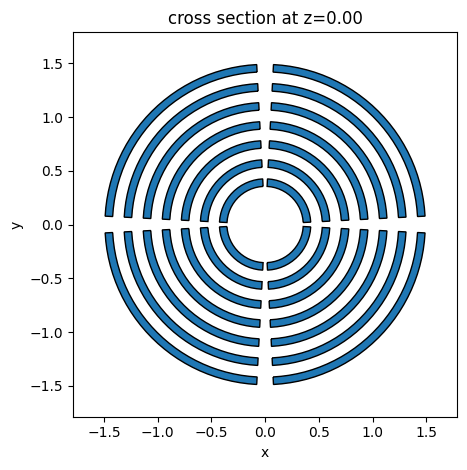

In [7]:
lib = gdstk.Library()

# Geometry must be placed in cells.
cell = lib.new_cell("BULLSEYE")

central_inner_radius = 0.355                   #initial inner radius
ring_width = 0.07                     #rings' width
ring_height = 0.2                   #rings' height
theta1 = 3 * np.pi / 180
theta2 = 87 * np.pi / 180
ringsNumbers = 7
vertexIncrement = 0.1075
ringNumber = 7
xOrigin = 0
yOrigin = 0


for i in range(ringsNumbers):
    for j in range(4):
        gcSlice = gdstk.ellipse(
            (xOrigin, yOrigin),
            central_inner_radius + i * (vertexIncrement + ring_width),
            central_inner_radius + i * (vertexIncrement + ring_width) + ring_width,
            theta1 + j*np.pi/2,
            theta2 + j*np.pi/2,
            layer=1,
            datatype=1,
            tolerance=0.0005
        )
        cell.add(gcSlice)
gc_etch = td.Geometry.from_gds(
        cell, gds_layer=1, axis=2, slab_bounds=(-ring_height/2, ring_height/2)
    )

gc_etch.plot(z=0)
plt.show()

mat_etch = td.Medium(permittivity = 1, name = 'air')
etch = td.Structure(
    geometry = gc_etch,
    medium = mat_etch,
    name = 'etch'
)

In [8]:
dipole_source = td.PointDipole(
    center = (0, 0, 0),
    source_time = td.GaussianPulse(
        freq0 = freq0,
        fwidth = fwidth),
    polarization = 'Ex',
    name = 'dipole_source'
)

In [9]:
time_monitor_1 = td.FieldTimeMonitor(
    name = 'time_monitor_1',
    size = [0, 0, 0],
    center = [0.1, 0.1, 0],
    start = t_start
)

time_monitor_2 = td.FieldTimeMonitor(
    name = 'time_monitor_2',
    size = [0, 0, 0],
    center = [0.1, 0.2, 0],
    start = t_start
)

time_monitor_3 = td.FieldTimeMonitor(
    name = 'time_monitor_3',
    size = [0, 0, 0],
    center = [0.2, 0.2, 0],
    start = t_start
)

time_monitor_4 = td.FieldTimeMonitor(
    name = 'time_monitor_4',
    size = [0, 0, 0],
    center = [0.2, 0.1, 0],
    start = t_start
)

time_monitors = [time_monitor_1, time_monitor_2, time_monitor_3, time_monitor_4]

In [10]:
mode_monitor = td.FieldMonitor(
    center = (0, 0, 0),
    size = (td.inf, td.inf, 0),
    fields = ['Ex', 'Ey', 'Ez'],
    freqs = monitor_freq,
    name = 'central_mode_monitor'
)

In [11]:
far_field_monitor = td.FieldProjectionAngleMonitor(
    center = (0, 0, offset_monitor),
    size = (td.inf, td.inf, 0),
    name = 'far_field_monitor',
    freqs = monitor_freq,
    normal_dir = '+',
    phi = np.linspace(0, 2 * np.pi, 181),
    theta = np.linspace(0, np.pi, 91)
)

In [21]:
sim_Q = td.Simulation(
    center = (0, 0, 0),
    size = sim_size,
    grid_spec = td.GridSpec.uniform(dl = dl),
    run_time = t_stop,
    sources = [dipole_source],
    monitors = time_monitors,
    structures = [slab, etch],
    medium = vacuum,
    shutoff = 1e-7,
    symmetry = [-1, 1, 0]
)

01:35:12 UTC WARNING: Structure at structures[1] was detected as being less than
             half of a central wavelength from a PML on side x-min. To avoid    
             inaccurate results or divergence, please increase gap between any  
             structures and PML or fully extend structure through the pml.      

             WARNING: Suppressed 3 WARNING messages.                            

In [22]:
sim_Q.plot_3d()

In [23]:
task_id = web.upload(sim_Q, task_name = 'cavity_Q')

01:35:30 UTC Created task 'cavity_Q' with task_id                               
             'fdve-ab4c7ffb-9b9d-4afc-8e15-dc79ebbe5f5e' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=559083;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ab4c7ffb-9b9d-4afc-8e15-dc79ebbe5f5e\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=359407;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ab4c7ffb-9b9d-4afc-8e15-dc79ebbe5f5e\taskId]8;;\]8;id=559083;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ab4c7ffb-9b9d-4afc-8e15-dc79ebbe5f5e\=]8;;\]8;id=479174;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ab4c7ffb-9b9d-4afc-8e15-dc79ebbe5f5e\fdve]8;;\]8;id=559083;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ab4c7ffb-9b9d-4afc-8e15-dc79ebbe5f5e\-ab4c7ffb-9b9]8;;\
             ]8;id=559083;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ab4c7ffb-9b9d-4afc-8e15-dc79ebbe5f5e\d-4afc-8e15-dc79ebbe5f5e']8;;\.

Output()

In [24]:
web.start(task_id)
web.monitor(task_id, verbose = True)

01:35:34 UTC status = queued

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

Output()

01:35:49 UTC status = preprocess

01:35:52 UTC Maximum FlexCredit cost: 0.041. Use 'web.real_cost(task_id)' to get
             the billed FlexCredit cost after a simulation run.

             starting up solver

             running solver

Output()

Output()

01:36:25 UTC status = postprocess

01:36:28 UTC status = success

             View simulation result at                                          
             ]8;id=552028;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ab4c7ffb-9b9d-4afc-8e15-dc79ebbe5f5e\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=730084;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ab4c7ffb-9b9d-4afc-8e15-dc79ebbe5f5e\taskId]8;;\]8;id=552028;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ab4c7ffb-9b9d-4afc-8e15-dc79ebbe5f5e\=]8;;\]8;id=20638;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ab4c7ffb-9b9d-4afc-8e15-dc79ebbe5f5e\fdve]8;;\]8;id=552028;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ab4c7ffb-9b9d-4afc-8e15-dc79ebbe5f5e\-ab4c7ffb-9b9]8;;\
             ]8;id=552028;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ab4c7ffb-9b9d-4afc-8e15-dc79ebbe5f5e\d-4afc-8e15-dc79ebbe5f5e']8;;\.

In [25]:
sim_data = web.load(task_id, path='data/sim_data_Q.hdf5')
print(sim_data.log)

Output()

01:36:39 UTC loading simulation from data/sim_data_Q.hdf5

             WARNING: Structure at structures[1] was detected as being less than
             half of a central wavelength from a PML on side x-min. To avoid    
             inaccurate results or divergence, please increase gap between any  
             structures and PML or fully extend structure through the pml.      

             WARNING: Suppressed 3 WARNING messages.                            

             WARNING: Simulation final field decay value of 4.02e-05 is greater 
             than the simulation shutoff threshold of 1e-07. Consider running   
             the simulation again with a larger 'run_time' duration for more    
             accurate results.                                                  

             WARNING: Warning messages were found in the solver log. For more   
             information, check 'SimulationData.log' or use                     
             'web.download_log(task_id)'.                                       

[01:35:48] WARNING: Structure at structures[1] was detected as being less than  
           half of a central wavelength from a PML on side x-min. To avoid      
           inaccurate results or divergence, please increase gap between any    
           structures and PML or fully extend structure through the pml.        
[01:35:49] USER: Simulation domain Nx, Ny, Nz: [200, 200, 124]                  
           USER: Applied symmetries: (-1, 1, 0)                                 
           USER: Number of computational grid points: 1.3109e+06.               
           USER: Subpixel averaging method: SubpixelSpec(attrs={},              
           dielectric=PolarizedAveraging(attrs={}, type='PolarizedAveraging'),  
           metal=Staircasing(attrs={}, type='Staircasing'),                     
           pec=PECConformal(attrs={}, type='PECConformal',                      
           timestep_reduction=0.3), type='SubpixelSpec')                        
           USER: Number of t

In [26]:
sim_data = td.SimulationData.from_file(fname = 'data/sim_data_Q.hdf5')

01:36:48 UTC WARNING: Structure at structures[1] was detected as being less than
             half of a central wavelength from a PML on side x-min. To avoid    
             inaccurate results or divergence, please increase gap between any  
             structures and PML or fully extend structure through the pml.      

             WARNING: Suppressed 3 WARNING messages.                            

In [27]:
resonance_finder = ResonanceFinder(freq_window=(monitor_freq[-1], monitor_freq[0]))
resonance_data = resonance_finder.run(signals=sim_data.data)
resonance_data.to_dataframe()

,decay,Q,amplitude,phase,error
freq,,,,,
3.203774e+14,8.204770e+11,1226.719565,187.583848,2.111641,0.002148
3.319802e+14,3.455772e+12,301.798412,84.262694,0.047195,0.010644
3.569841e+14,1.295024e+12,866.006340,38.889911,-2.343185,0.005085
4.196056e+14,8.189158e+12,160.972584,180.447061,2.765938,0.015051


<ipython-input-28-abf79d6369be>:16: RuntimeWarning: divide by zero encountered in divide
  wavelengths = td.constants.C_0 / freqs


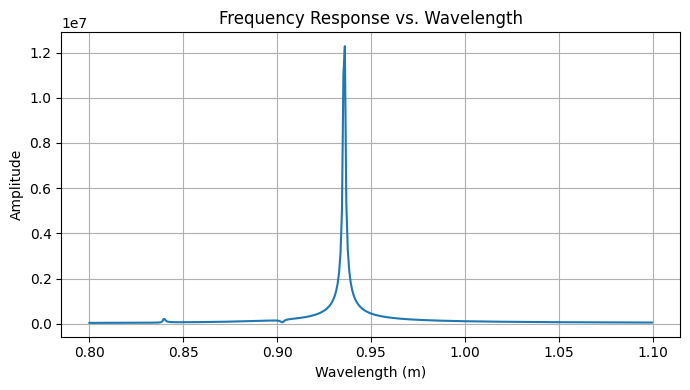

<Figure size 640x480 with 0 Axes>

In [28]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(1, 1, tight_layout=True, figsize=(7, 4))

# Extract the time response data
time_response = sim_data["time_monitor_1"].Ex.squeeze()

# Perform FFT and get the frequency response
freq_response = np.abs(np.fft.fft(time_response))

# Calculate the frequency values
freqs = np.linspace(0, 1 / sim_data.simulation.dt, len(time_response))

# Calculate the corresponding wavelengths
wavelengths = td.constants.C_0 / freqs

# Select the indices within the monitor frequency range
plot_inds = np.where((monitor_freq[-1] < freqs) & (freqs < monitor_freq[0]))

# Plot the frequency response with respect to wavelength
ax1.plot(wavelengths[plot_inds], freq_response[plot_inds])
ax1.set_xlabel("Wavelength (m)")
ax1.set_ylabel("Amplitude")
ax1.set_title("Frequency Response vs. Wavelength")
ax1.grid(True)

# Reverse the x-axis to show decreasing wavelength (optional)
#ax1.set_xlim(ax1.get_xlim()[::-1])

plt.show()
plt.savefig('Resonance_data')